In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import deque
from tf2.Kfocusingtf2 import FocusedLayer1D

# Credentials

In [2]:
lr_dict = {'all':0.01,
           'focus-1/Sigma:0': 0.01,'focus-1/Mu:0': 0.01,'focus-1/Weights:0': 0.01,
           'dense-1/Weights:0':0.01}
        
#lr_dict = {'all':0.0001}

mom_dict = {'all':0.9}
#decay_dict = {'all':0.9}
#mom_dict = {'all':0.9,'focus-1/Sigma:0': 0.25,'focus-1/Mu:0': 0.25,
#           'focus-2/Sigma:0': 0.25,'focus-2/Mu:0': 0.25}
    
decay_dict = {'all':0.9, 'focus-1/Sigma:0': 0.1,'focus-1/Mu:0':0.1}

clip_dict = {'focus-1/Sigma:0':(0.05,1.0),'focus-1/Mu:0':(0.0,1.0)}



np.random.seed(42)
tf.random.set_seed(42)

#cridentals
mode = {'d':'dense'
        ,'f':'focused'}
optimizer_s = {'a':'adam'
              ,'sl':'SGDwithLR'
              ,'rc':'RMSpropwithClip'
              ,'ac':'AdamwithCli'}

episodes = 600
iterations = 200
batch_size = 32
discount_rate = 0.95
learning_rate = 1e-3

loss_fn = keras.losses.MeanSquaredError()
accuracy = keras.metrics.MeanSquaredError()

# Neural Network Model

In [3]:
def build_model(N=32
                ,mode='dense'
                ,optimizer_s='adam'):
    
    keras.backend.clear_session()

    if optimizer_s == 'SGDwithLR':
        optimizer = SGDwithLR(lr_dict, mom_dict,decay_dict,clip_dict)
    elif optimizer_s == 'AdamwithCli':
        optimizer = AdamwithClip()
    elif optimizer_s=='RMSpropwithClip':
        optimizer = RMSpropwithClip(lr=0.001, rho=0.9, epsilon=None, decay=0.0,clips=clip_dict)
    elif optimizer_s=='adam':
        optimizer = keras.optimizers.Adam(lr=learning_rate)
    else:
        optimizer = SGD(lr=0.01, momentum=0.9)
    

    if mode=='dense':
        layer = keras.layers.Dense(32, activation="elu")
    elif mode=='focused':
        layer = FocusedLayer1D(N, name='focus-1', activation='elu', init_sigma=0.25)
        
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        layer,
        keras.layers.Dense(output_size)
    ])

    print(model.summary())

    return model, optimizer

# Plotting

In [4]:
def plotTheValues(scores):
    x = []
    y = []
    for i in range(0, len(scores)):
        x.append(int(i))
        y.append(int(scores[i]))

    plt.figure(figsize=(20, 15))

    plt.plot(x, y, label="score per run")

    plt.plot(x[-100:], [np.mean(y[-100:])] * len(y[-100:]), linestyle="--", label="last 100 runs average")

    trend_x = x[1:]
    z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
    p = np.poly1d(z)
    plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")


    plt.xlabel("episodes")
    plt.ylabel("scores")
    plt.legend(loc="upper left")

In [5]:
def statistic(scores, choices):
    choice = set(choices)
    print('Average Score: ',sum(scores)/len(scores))
    for i in choice:
        print(f"choice {i}:{mean(choices,i)}")

In [6]:
def lossAccComparison(dense, focused, name):
    plt.figure(figsize=(16,8))
    plt.title(name+'_loss_grahp')
    plt.plot(dense['loss'])
    plt.plot(focused['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['dense','focused'])
    plt.savefig('./graphs/'+name+'_loss_grahp.png', bbox_inches="tight")

    plt.figure(figsize=(16,8))
    plt.title(name+'_accuracy_grahp')
    plt.plot(dense['acc'])
    plt.plot(focused['acc'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['dense','focused'])
    plt.savefig('./graphs/'+name+'_accuracy_grahp.png', bbox_inches="tight")
    

In [7]:
mean = lambda lst, key: lst.count(key)/len(lst)

# Creating Data and Test Run on Environment

In [8]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [9]:
def training_step(batch_size):
    accuracy.reset_states()
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, output_size)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    accuracy.update_state(target_Q_values, Q_values)
    return float(loss), accuracy.result().numpy()

In [10]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, action

In [11]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [12]:
def train_env(env):
    scores = []
    choices = []
    metrics = {'loss':[], 'acc':[]}
    best_score = 0
    score = 0
    for episode in range(episodes):
        score = 0
        obs = env.reset()    
        for step in range(iterations):
            epsilon = max(1 - episode / 500, 0.01)
            
            obs, reward, done, action = play_one_step(env, obs, epsilon)
            
            choices.append(action)
            
            score += reward
            
            if done:
                break
                
        scores.append(score)
        if step > best_score:
            best_weights = model.get_weights()
            best_score = step
        print(f"\rEpisode: {episode+1}, Steps: {step+1}, eps: {epsilon}", end="")
        if episode > 50:
            lossValue, accurancyValue = training_step(batch_size)
            metrics['loss'].append(lossValue)
            metrics['acc'].append(accurancyValue)

    model.set_weights(best_weights)
    
    return scores, choices, metrics

# MountainCar section

In [35]:
env = gym.make('MountainCar-v0')

input_shape = env.observation_space.shape
output_size = env.action_space.n

replay_memory = deque(maxlen=2000)

In [36]:
model, optimizer = build_model(mode=mode['d']
                               ,optimizer_s=optimizer_s['a'])
MountainCar_model_history_dense = model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
scores, choices, denseMetrics = train_env(env=env)

Episode: 52, Steps: 200, eps: 0.898WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 200, eps: 0.010000000000000009

Average Score:  -200.0
choice 0:0.42361666666666664
choice 1:0.48945
choice 2:0.08693333333333333


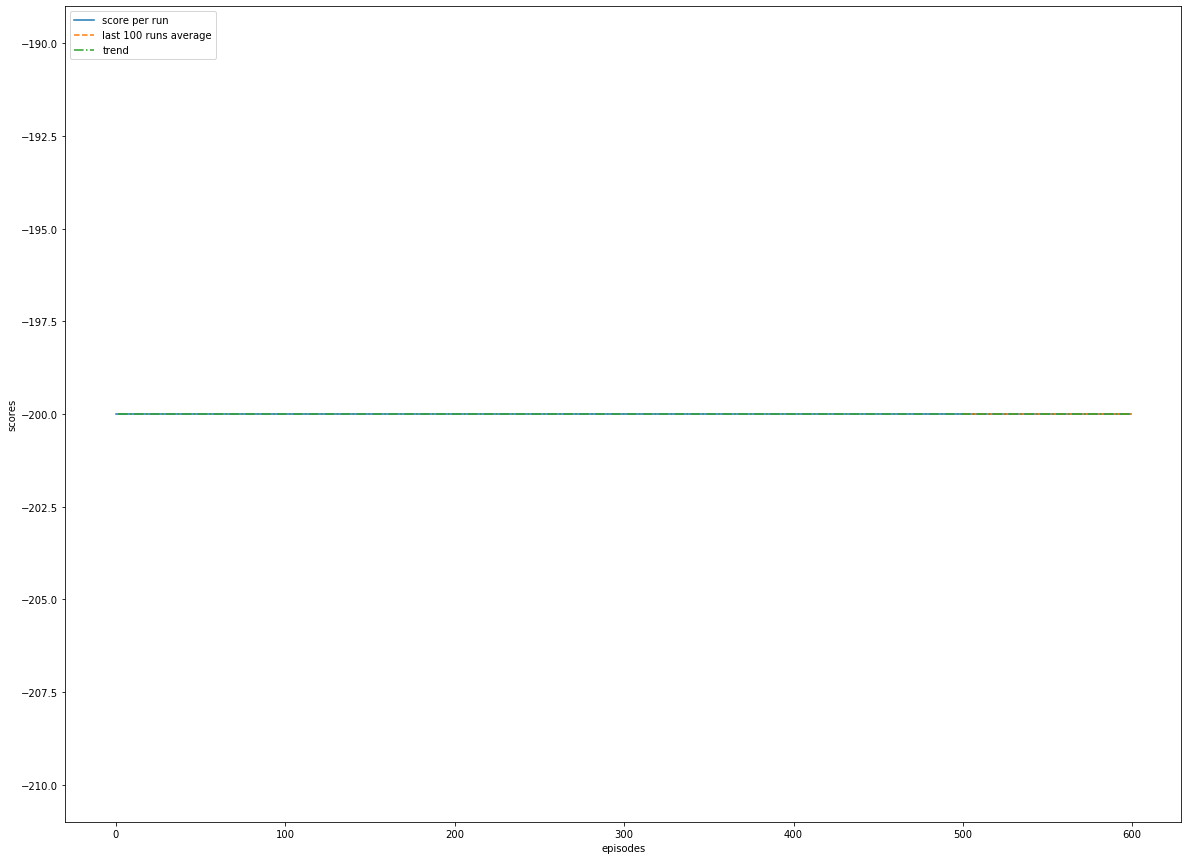

In [38]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

# FocusedNN Graphs

In [39]:
model, optimizer = build_model(mode=mode['f']
                               ,optimizer_s=optimizer_s['a'])
MountainCar_model_history_focused = model

{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
scores, choices, focusedMetrics  = train_env(env=env)

Episode: 52, Steps: 200, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 200, eps: 0.010000000000000009

Average Score:  -200.0
choice 0:0.4625666666666667
choice 1:0.48286666666666667
choice 2:0.054566666666666666


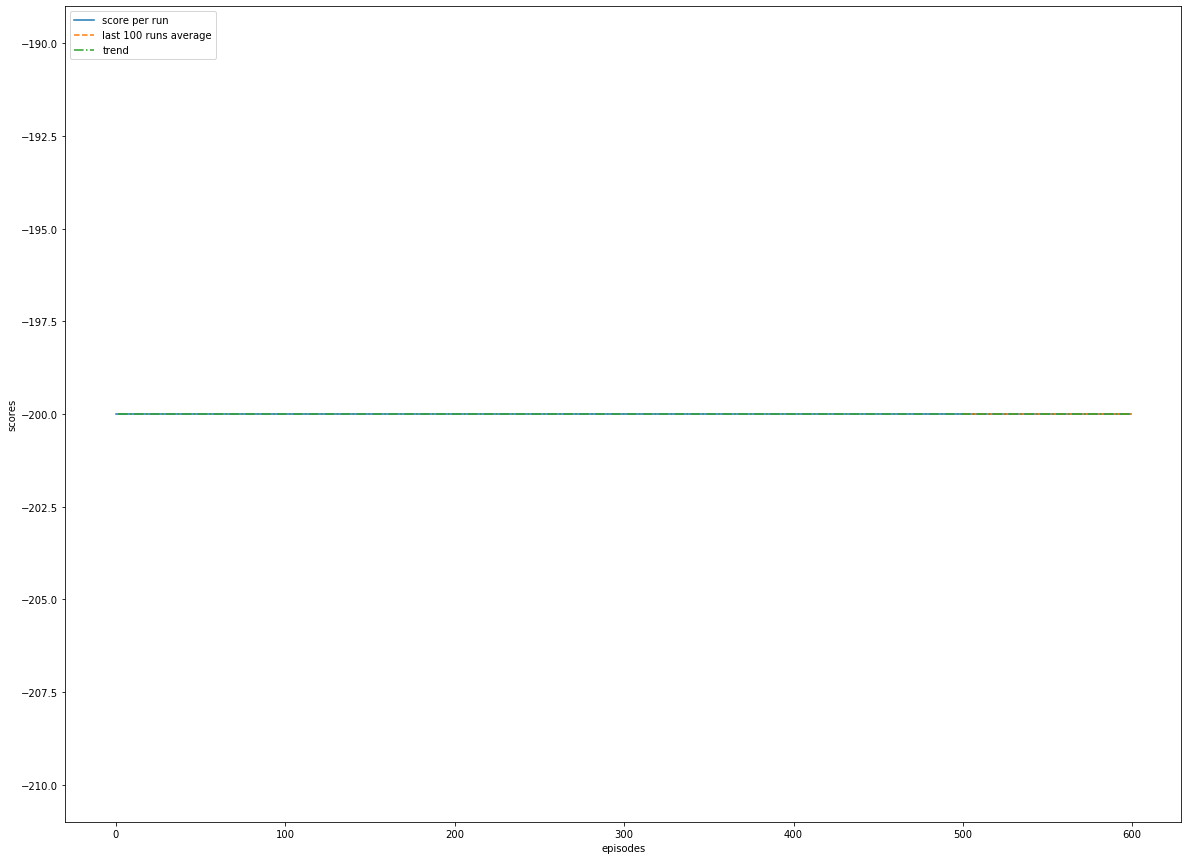

In [41]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

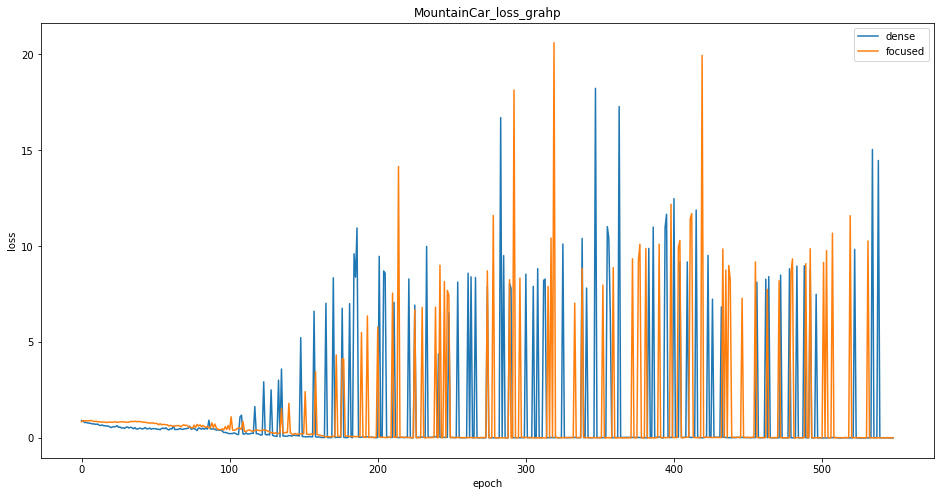

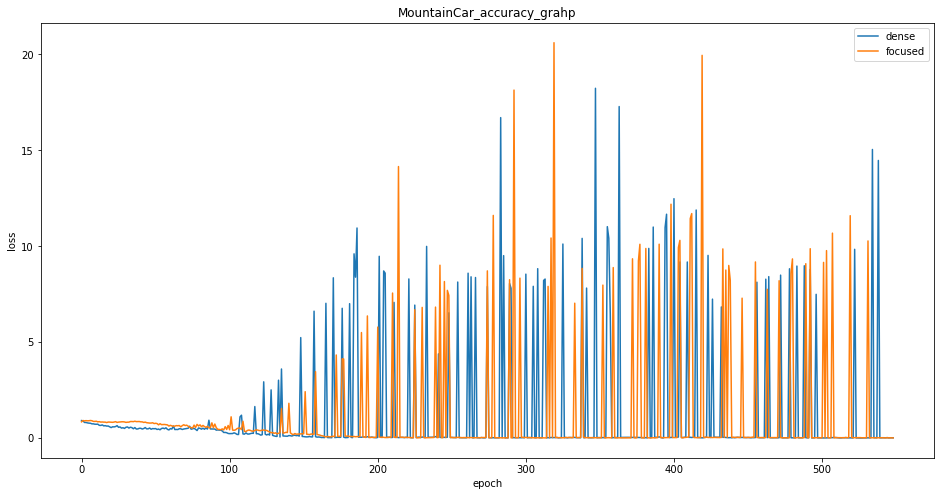

In [42]:
lossAccComparison(dense=denseMetrics
                 ,focused=focusedMetrics
                 ,name='MountainCar')

# CartPole section

In [13]:
env = gym.make('CartPole-v1')

input_shape = env.observation_space.shape
output_size = env.action_space.n

replay_memory = deque(maxlen=2000)

In [14]:
model, optimizer = build_model(mode=mode['d']
                               ,optimizer_s=optimizer_s['a'])
CartPole_model_history_dense = model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
scores, choices, denseMetrics = train_env(env=env)

Episode: 52, Steps: 21, eps: 0.898WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 9, eps: 0.0111000000000000009

Average Score:  22.211666666666666
choice 0:0.48825692203796806
choice 1:0.511743077962032


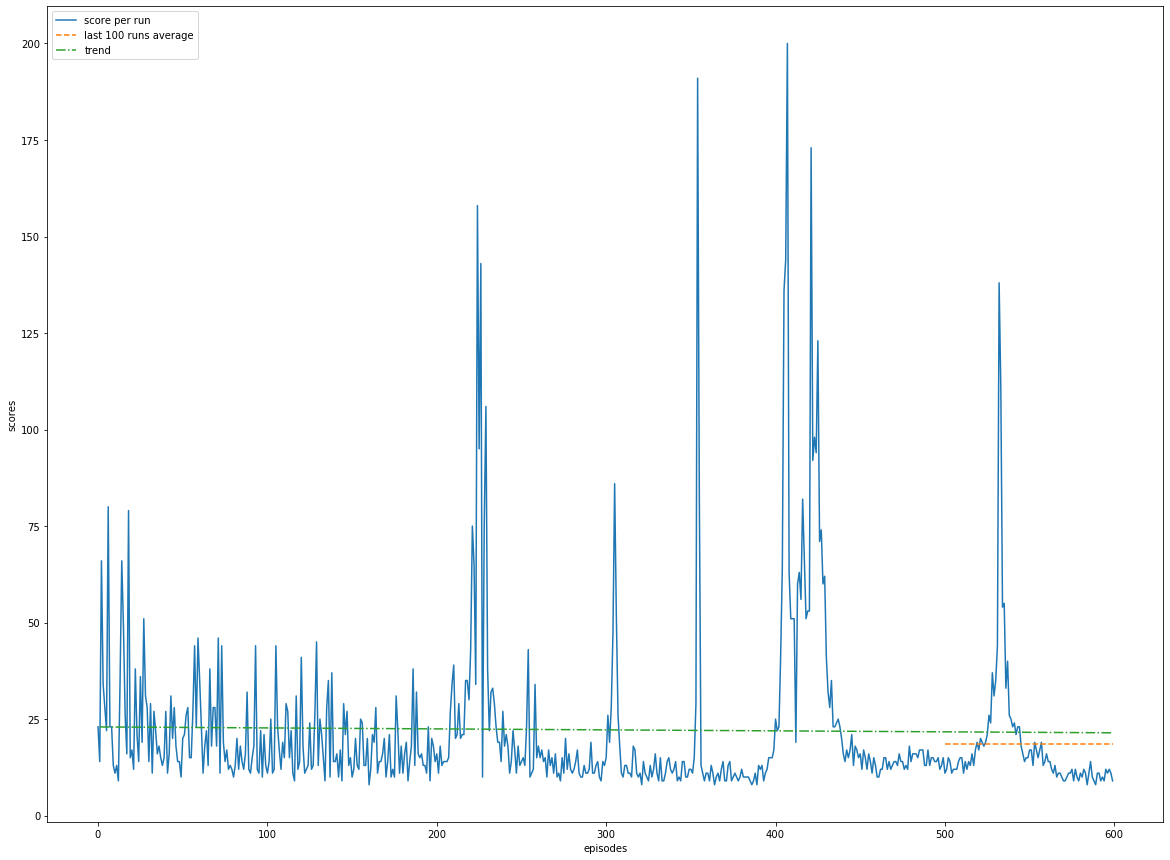

In [16]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

# FocusedNN Graphs

In [17]:
model, optimizer = build_model(mode=mode['f']
                               ,optimizer_s=optimizer_s['a'])
CartPole_model_history_focused = model

{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,346
Trainable params: 1,346
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
scores, choices, focusedMetrics = train_env(env=env)

Episode: 52, Steps: 15, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 31, eps: 0.011000000000000009

Average Score:  24.02166666666667
choice 0:0.48088531187122735
choice 1:0.5191146881287726


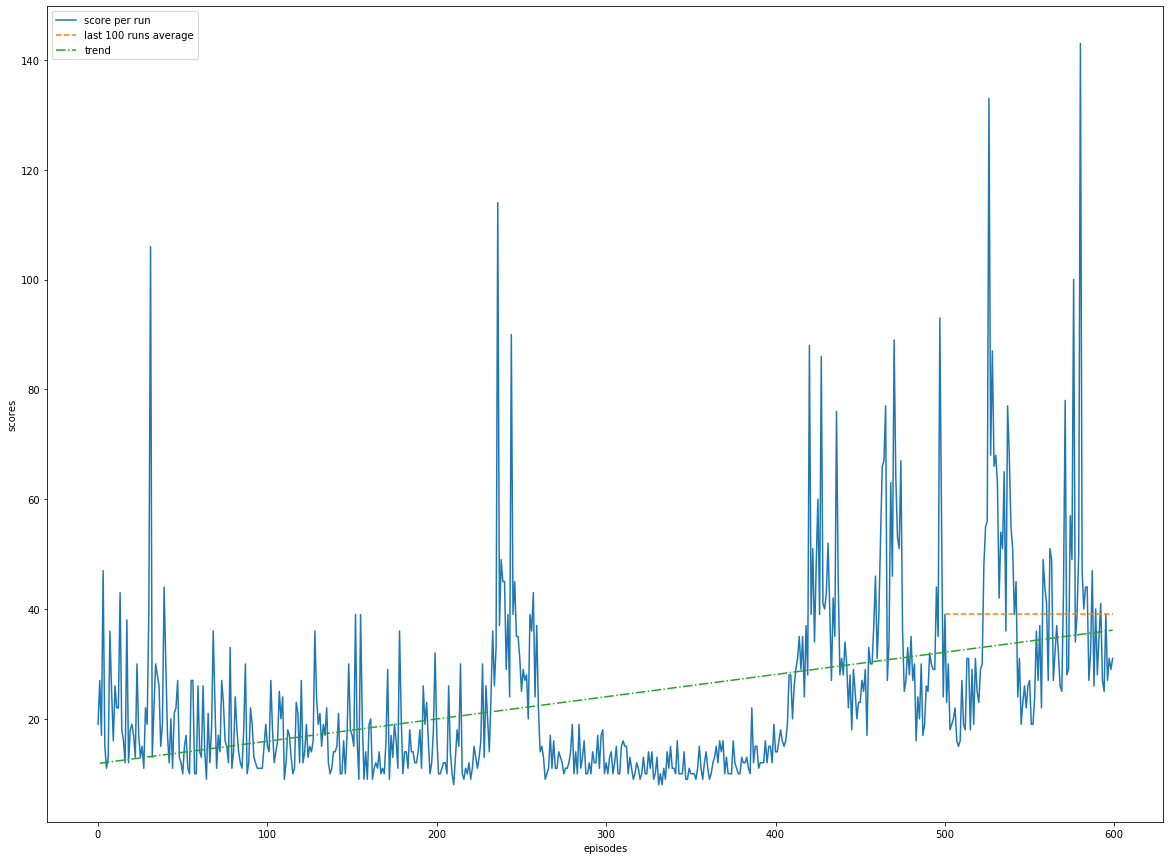

In [19]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

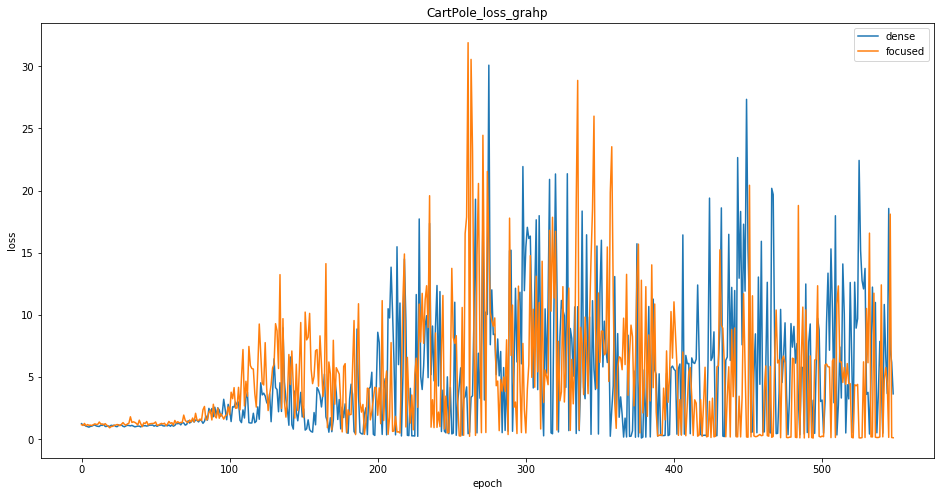

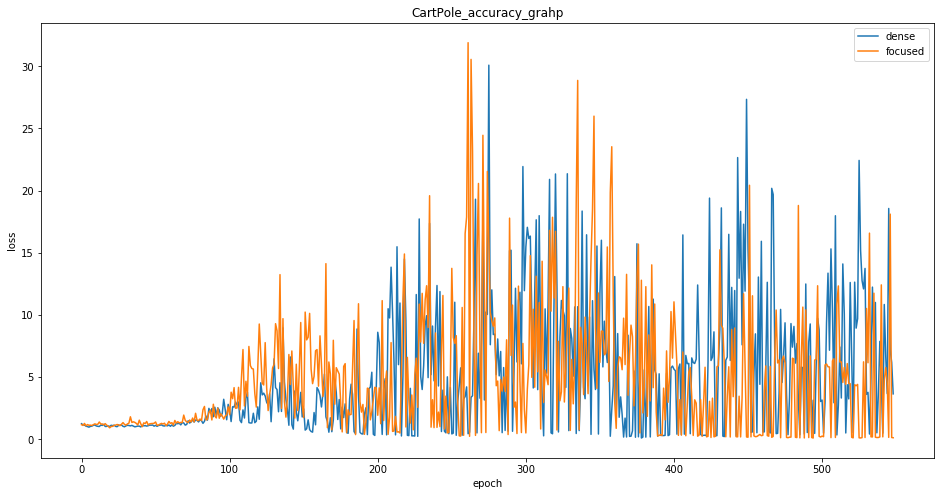

In [24]:
lossAccComparison(dense=denseMetrics
                 ,focused=focusedMetrics
                 ,name='CartPole')

# Acrobot Section

In [13]:
env = gym.make('Acrobot-v1')

input_shape = env.observation_space.shape
output_size = env.action_space.n

replay_memory = deque(maxlen=2000)

In [14]:
model, optimizer = build_model(mode=mode['d']
                               ,optimizer_s=optimizer_s['a'])
Acrobot_model_history_dense = model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
scores, choices, denseMetrics = train_env(env=env)

Episode: 52, Steps: 200, eps: 0.898WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 200, eps: 0.010000000000000009

Average Score:  -199.975
choice 0:0.3929342345420754
choice 1:0.5356496953836666
choice 2:0.07141607007425804


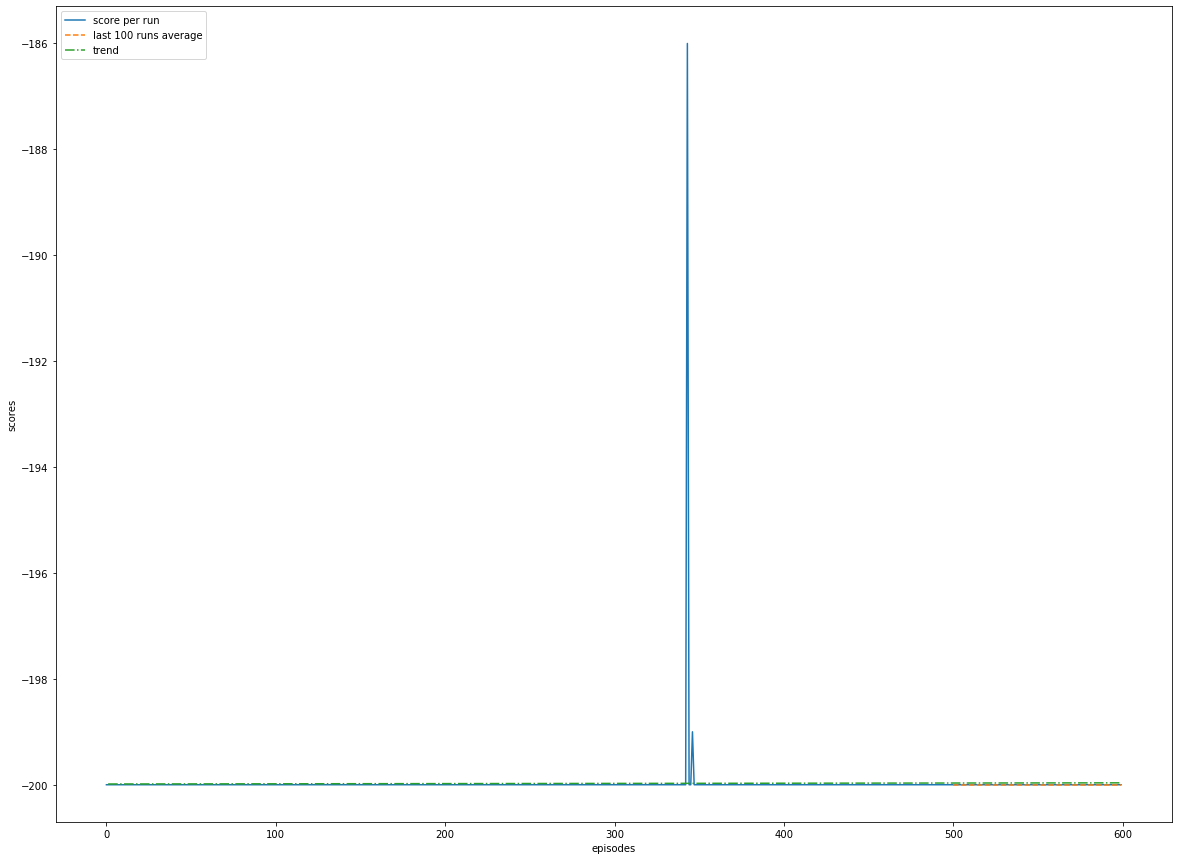

In [16]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

# FocusedNN Graphs

In [17]:
model, optimizer = build_model(mode=mode['f']
                               ,optimizer_s=optimizer_s['a'])
Acrobot_model_history_focused = model

{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
scores, choices, focusedMetrics = train_env(env=env)

Episode: 52, Steps: 200, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 573, Steps: 200, eps: 0.010000000000000009

In [ ]:
statistic(scores=scores
          ,choices=choices)
plotTheValues(scores=scores)

In [ ]:
lossAccComparison(dense=denseMetrics
                 ,focused=focusedMetrics
                 ,name='Acrobot')